# Deep Neural Network For The Detection Of Eye Movements

### Presented to:

Dr.Sahar Ali Fawzy

Eng.Nermien Khalifa

### Team Names:

Shrouk Hesham 19106271

Rawan Ramdan 19106199

Nadeen Nassif 19105325

Zahra Omar Elzeiry 18102297

In [2]:
!pip install torch

In [3]:
!pip install classifier

In [4]:
import numpy as np
import os
from skimage.measure import label
from sklearn import metrics
from scipy import io
#from IPython import display
# Pytorch imports:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [5]:
# Neural Network Architecture: 
class UNet(nn.Module):
    def __init__(self,dim=2,ks=5,mp=5):
        super(UNet,self).__init__()
        ''''
        dim: number of output features
        ks: kernel size of convolutional operations
        mp: kernel size of max pooling
        '''
        Ch = [1,10,20,40,dim] # number of features
        pd = int((ks-1)/2) # number of bins for border padding on each side
 
        self.c0 = nn.Sequential(
            nn.Conv2d(Ch[0],Ch[1],(ks,2),stride=1,padding=(pd,0)),
            nn.ReLU(True),
            nn.BatchNorm2d(Ch[1],affine=True),
        )
        self.c1 = nn.Sequential(
            nn.Conv1d(Ch[1],Ch[2],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),
        )
        self.p1 = nn.Sequential(
            nn.MaxPool1d(kernel_size=mp,stride=mp),
        )
        self.c2 = nn.Sequential(
            nn.Conv1d(Ch[2],Ch[2],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),
        )
        self.p2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=mp,stride=mp),
        )
        self.c3 = nn.Sequential(  
            nn.Conv1d(Ch[2],Ch[2],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True), 
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(Ch[2],Ch[2],mp,stride=mp,padding=0),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),
        )
        self.c4 = nn.Sequential(  
            nn.Conv1d(Ch[3],Ch[2],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),  
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(Ch[2],Ch[2],mp,stride=mp,padding=0),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),
        )
        self.c5 = nn.Sequential(
            nn.Conv1d(Ch[3],Ch[2],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[2],affine=True),
        )
        self.c6 = nn.Sequential(
            nn.Conv1d(Ch[2],Ch[1],ks,stride=1,padding=pd),
            nn.ReLU(True),
            nn.BatchNorm1d(Ch[1],affine=True),
        ) 
        self.c7 = nn.Conv1d(Ch[1],Ch[4],1,stride=1,padding=0)     
        
        self.sftmax = nn.Softmax(dim=1)
        
    def forward(self,input,outkeys):
        
        out = {}
        out['in'] = input
        out['c0'] = self.c0(input).squeeze(3)
        out['c1'] = self.c1(out['c0'])
        out['p1'] = self.p1(out['c1'])
        out['c2'] = self.c2(out['p1'])
        out['p2'] = self.p2(out['c2'])
        out['c3'] = self.c3(out['p2'])
        out['up1'] = self.up1(out['c3']) 
        out['c4'] = self.c4(torch.cat((out['p1'],out['up1']),1))
        out['up2'] = self.up2(out['c4']) 
        out['c5'] = self.c5(torch.cat((out['c1'],out['up2']),1))
        out['c6'] = self.c6(out['c5'])
        out['out'] = self.sftmax(self.c7(out['c6']))
        
        return [out[key] for key in outkeys]

In [6]:
# helper functions: 
# Initialization of weights of convolutional layers
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)

    
# Multi-class loss
class MCLoss(nn.Module):
    '''
    Torch cost function with foward method. 
    '''
    def __init__(self):
        super(MCLoss,self).__init__()
           
    def forward(self,prediction,target):
        
        epsilon = 1e-7
        prediction = torch.clamp(prediction,min=epsilon)
        prediction = torch.clamp(prediction,max=1-epsilon)  
        E = - torch.mean( target * torch.log(prediction) )

        return E
    
    
def lr_decay(optimizer, lr_decay=0.5):
    '''
    Decay learning rate by a factor of lr_decay
    '''
 
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
        
    return optimizer


def add_noise(X,Y,sd):
    """
    Add white noise to data for data augmentation
    
    Parameters
    ----------
    X: array-like, horizontal eye trace
    Y: array-like, vertical eye trace
    sd: list of floats, shape=2, standard deviation of the white noise in a range [min,max]
    
    Output
    ------
    Xnoise: array-like, horizontal eye trace + white noise
    Ynoise: array-like, vertical eye trace + white noise
    
    """
    t = X.shape[1]
    N = X.shape[0]
    np.random.seed(20)
    
    trial_noise_level = np.tile(np.random.rand(N,1) * (sd[1]-sd[0]) + sd[0], (1,t));
    noise4X = np.multiply(np.random.randn(N,t),trial_noise_level)
    noise4Y = np.multiply(np.random.randn(N,t),trial_noise_level)
    
    return X+noise4X , Y+noise4Y

def merge_saccades(Prediction,samp_freq,min_sacc_dist=10):
    '''
    Merge saccades that are too close in time
    
    Parameters
    ----------
    Prediction: array-like, shape={(n_timepoints),(n_samples,n_timepoints)}, binary saccade prediction
    samp_freq: int, sampling frequency in Hz
    min_sacc_dist: int, minimum saccade distance for merging of saccades, default=10 ms

    Output
    ------
    Prediction_new = array-like, shape={(n_timepoints),(n_samples,n_timepoints)}, binary saccade prediction
    '''
    Prediction2 = (Prediction.copy()==0).astype(int)
    Prediction_new = Prediction.copy()
    
    if len(Prediction.shape)<2: # case where network output is a vector
        l = label(Prediction2)
        first_label = 1 + int(l[0]==1)
        last_label = np.max(l) - int(l[-1]==np.max(l))
        for i in range(first_label,last_label+1):
            if np.sum(l==i)<int(min_sacc_dist*(samp_freq/1000)):
                Prediction_new[l==i] = 1
                    
    else:  # case where network output is a matrix
        for n in range(Prediction.shape[0]):
            l = label(Prediction2[n,:])
            first_label = 1 + int(l[0]==1)
            last_label = np.max(l) - int(l[-1]==np.max(l))
            for i in range(first_label,last_label+1):
                if np.sum(l==i)<int(min_sacc_dist*(samp_freq/1000)):
                    Prediction_new[n,l==i] = 1
                    
    return Prediction_new        
            
    
def binary_prediction(output,samp_freq,p=0.5,min_sacc_dist=1,min_sacc_dur=1): 
    '''
    Predict saccades from network probability output.
    Apply threshold on softmax and delete saccade of length < min_sacc_dur.
    
    Parameters
    ----------
    output: array-like, shape={(n_timepoints), (n_samples,n_timepoints)}, network softmax output
    samp_freq: int, sampling frequency in Hz
    p: float, threshold for saccade class, default=0.5
    min_sacc_dur: int, minimum saccade duration for removal of small saccades, default=1 (==no filtering)
    
    Output
    ------
    S_predic: array-like, shape={(n_timepoints), (n_samples,n_timepoints)}, fixation(=0) and saccade(=1) prediction for each time_bin in the network output
    
    '''
    S_predic = (output>p).astype(int)
    if min_sacc_dist!=1:
        # merge saccades with distance < min_sacc_dist
        S_predic = merge_saccades(S_predic,samp_freq,min_sacc_dist)
    
    # delete small saccades                
    if min_sacc_dur>1:
        if len(output.shape)<2:
            # case where network output is a vector
            l = label(S_predic)
            for j in range(1,np.max(l)+1):
                s = np.sum(l==j)
                if s<min_sacc_dur:
                    S_predic[l==j] = 0
        else:
            # case where network output is a matrix; assume: first dimension: number of samples
            for n in range(output.shape[0]):
                l = label(S_predic[n,:])
                for j in range(1,np.max(l)+1):
                    s = np.sum(l==j)
                    if s<min_sacc_dur:
                        S_predic[n,l==j] = 0                        
    return S_predic  


def cluster_belonging (logical_array,index):
    '''
    return the cluster of 'True' values that contain a time point
    logical_array: 1D array of 'True' and 'False'
    index value between 0 and length of logical_array
    '''
    
    labels = label(logical_array)
    
    cluster=(np.arange(0,len(logical_array))*0).astype(bool)
    cluster[labels==labels[index]]=True              
    return cluster


def accuracy (predicted,truth):
    '''
    Computes accuracy of prediction compared to groundtruth (in terms of true and false positive and false negative detections)
    Implemented for saccades only (no pso)
    
    Parameters
    ----------
    predicted: array-like, shape={(n_timepoints),(n_samples,n_timepoints)}, fixation(=0) and saccade(=1) prediction
    truth: array-like, shape={(n_timepoints),(n_samples,n_timepoints)}, fixation(=0) and saccade(=1) labels
    
    Output
    ------
    true_pos: float, number of correctly detected saccades
    false_pos: float, number of wrongly detected saccades
    false_neg: float, number of missed saccades
    on_distance: array-like, time-bin difference between true and predicted saccade onset for all true positives
    off_distance: array-like, time-bin difference between true and predicted saccade offset for all true positives
    
    '''
    
    if len(truth.shape)>1:
        # assume first dimension is number of samples
        batchsize = predicted.shape[0]
    else:
        # if input=vector, set batchsize to 1
        batchsize = 1
        # enforce two dimensions
        truth = np.atleast_2d(truth)
        predicted = np.atleast_2d(predicted)
        
    truth_copy = truth.copy()
    truth = truth.astype(int)
    pred_copy = predicted.copy()
    
    # Velocity
    Diff_p = np.diff(predicted,axis=1)
    Diff_t = np.diff(truth,axis=1)
    
    # count variables:
    true_pos = 0
    false_neg = 0
    false_pos = 0
    on_distance = []
    off_distance = []
    
    # loop trough samples:
    for i in range(batchsize):
        trace_t = Diff_t[i,:]
        trace_p = Diff_p[i,:]
        
        # find start and end of saccades
        # labels from prediction
        start_p = np.argwhere(trace_p==1)+1 # add one as the diff is shifted one bin early
        end_p = np.argwhere(trace_p==-1)+1 # add one as python indexing doesn't include last index in range
        # labels from ground truth
        start_t = np.argwhere(trace_t==1)+1 # add one as the diff is shifted one bin early
        end_t = np.argwhere(trace_t==-1)+1 # add one as python indexing doesn't include last index in range
        
        
        # exclude border saccades in ground truth data:
        if (truth[i,0]==1):
            end_t = end_t[1:]
        if (truth[i,-1]==1):
            start_t = start_t[:-1]
    
        if len(start_t)!=0: # if there is at least one saccade
            
            # if all conditions met, loop through each true saccade
            for j in range(len(start_t)):
                
                content_of_pred = pred_copy[i,int(start_t[j]):int(end_t[j])] #content of prediction during true saccade duration 
                
                if content_of_pred!=[]:
                    if np.mean(content_of_pred)==0:
                        # checks if no saccade has been detected by network
                        # add false negative detection
                        false_neg += 1
                    else:
                        
                        if content_of_pred[0]==1: # the matching predicted saccade start earlier than the ground truth
                            
                            # if the predicted label starts at the signal boundary
                            pred_start_ind = np.argwhere(np.diff(pred_copy[i,:])==1)
                            ind_before_true_start = pred_start_ind[pred_start_ind<start_t[j]] # predicted start before true start
                                                         
                            if len(ind_before_true_start)==0:
                                start = 0; # set predicted start to first bin because it is before the start of the trace
                            else:

                                start = ind_before_true_start[-1] + 1

                            diff_pred_copy = np.diff(pred_copy[i,:])
                            if pred_copy[i,-1]==1:
                                #if the prediction ends with a saccade, set the last bind of the differential to -1 to add an end
                                diff_pred_copy[-1] = -1 
                                
                            # get the predicted end bin:    
                            pred_end_ind = np.argwhere(diff_pred_copy==-1) +1 #get all saccade end bins in trace
                            ind_after_start = pred_end_ind[pred_end_ind>start] #only consider end bins that occur after start
                            end = ind_after_start[0] # use first end bin after predicted saccade start as saccade end

                            pred_copy[i,cluster_belonging (pred_copy[i,:].astype(bool),start_t[j])]=0   # delete matching pairs
                            truth_copy[i,cluster_belonging (truth_copy[i,:],start_t[j])]=0 # to not consider them for the next iteration
                            true_pos += 1
                            
                        else:
                            pred_start_ind = np.argwhere(np.diff(pred_copy[i,:])==1)
                            # predicted start from true start onwards
                            ind_from_true_start = pred_start_ind[pred_start_ind>=start_t[j]] 
                             
                            start = ind_from_true_start[0] +1 # set predicted start index to first found after true start
                            
                            diff_pred_copy=np.diff(pred_copy[i,:])
                            if pred_copy[i,-1]==1:
                                diff_pred_copy[-1]=-1
                                
                            # get the predicted end bin:     
                            pred_end_ind = np.argwhere(diff_pred_copy==-1) +1 #get all saccade end bins in trace
                            ind_after_start = pred_end_ind[pred_end_ind>start] #only consider end bins that occur after start
                            end = ind_after_start[0] # use first end bin after predicted saccade start as saccade end

                            pred_copy[i,cluster_belonging (pred_copy[i,:],start)]=0   # delete matching pairs
                            truth_copy[i,cluster_belonging (truth_copy[i,:],start)]=0 
                            
                            true_pos += 1
                        
                        on_distance.append(int(start)-int(start_t[j]))
                        off_distance.append(int(end)-int(end_t[j]))
    
        # remove border sacades from predicted trace
        if (pred_copy[i,0]==1):
            pred_copy[i,cluster_belonging (pred_copy[i,:],0)]=0 
        if (pred_copy[i,-1]==1):
            pred_copy[i,cluster_belonging (pred_copy[i,:],len(pred_copy[i,:])-1)]=0 
            
        # count false positives 
        false_pos=false_pos+len(np.argwhere(np.diff(pred_copy[i,:])==1))
        
    return true_pos,false_pos,false_neg,on_distance,off_distance


def EM_saccade_detection(X,Y,lambda_param=6,min_sacc_dist=5,min_sacc_dur=10,sampfreq=1000):
    # Addapted from Engbert, Ralf, and Konstantin Mergenthaler. "Algorithm for Microsaccades are triggered by low retinal image slip."

    n_samples,n_time = X.shape
    Vx=np.zeros((n_samples,n_time))
    Vy=np.zeros((n_samples,n_time))
    Eta_x=np.zeros(n_samples)
    Eta_y=np.zeros(n_samples)
    Sacc_out=np.zeros((n_samples,n_time),dtype=bool)
    for i in np.arange(0,np.shape(X)[0]):
        Vx[i,:]=np.convolve(X[i,:], np.divide([-1,-1,0,1,1],6), mode='same') # running average over 5 bins
        Vy[i,:]=np.convolve(Y[i,:], np.divide([-1,-1,0,1,1],6), mode='same')
        # set edges values to the last values
        Vx[i,0:2]=Vx[i,3]
        Vy[i,0:2]=Vy[i,3]
        Vx[i,n_time-2:n_time]=Vx[i,n_time-3]
        Vy[i,n_time-2:n_time]=Vy[i,n_time-3]
        # compute thresholds
        Eta_x[i]=np.median((Vx[i,:]-np.median(Vx[i,0:2]))**2);
        Eta_y[i]=np.median((Vy[i,:]-np.median(Vy[i,0:2]))**2);
        # saccade estimate
        
        Sacc_out[i,:]=(np.divide(Vx[i,:],(lambda_param*np.sqrt(Eta_x[i])))**2+np.divide(Vy[i,:],(lambda_param*np.sqrt(Eta_y[i])))**2)>1
        
        # merge saccades closer than min_sacc_dist (ms)
        Sacc_out[i,:] = merge_saccades(Sacc_out[i,:],sampfreq,min_sacc_dist)
        
        labels = label(Sacc_out[i,:])
        for j in np.arange(1,np.max(labels)+1):
            
            if np.sum(labels==j)<int(min_sacc_dur*(sampfreq/1000)): # remove saccades smaller than min_sacc_dur (ms)
                
                Sacc_out[i,labels==j]=False
    return Sacc_out

In [7]:
import numpy as np
import os
import math
from skimage.measure import label
from scipy import io
#from IPython import display
# Pytorch imports:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.metrics import cohen_kappa_score as cohenskappa
import matplotlib.pyplot as plt


class DNN():
    '''
    Convolutional Neural Network (U-Net Variant) for Saccade Detection
    
    Parameters
    ----------
    max_iter: int, maximum number of epochs during training, default=500
        
    sampfreq: {float,int}, sampling frequency of data in Hz, default=1000 Hz
    
    lr: float, learning rate, default=0.001
    
    weights_name: str, filename of weights to save or load, will automatically be stored and load in local folder 'training', default: 'weights'
        
    min_sacc_dist: int, minimum distance between two saccades in ms for merging of saccades, default=1
    
    min_sacc_dur: int, minimum saccade duration in ms for removal of small events, default=6ms
        
    augmentation: bool, whether or not to use data augmentation for training. Default: True

    inf_correction: float, value to replace Infs occuring after differential of input signal

    val_samples: int, number of validation samples (for early stopping criterion)
    
    doDiff: bool, whether input is differentiated or not; default: True

    '''
    def __init__(self, max_iter=500, sampfreq=1000,
                 lr=0.001, weights_name='weights',
                 min_sacc_dist=1,min_sacc_dur=6,augmentation=True,
                 ks=5,mp=5,inf_correction=1.5,val_samples=30,
                 doDiff=True):
        
        if max_iter<10:
            max_iter = 10
        self.max_iter = max_iter
        self.sampfreq = sampfreq
        self.lr = lr
        self.weights_name = weights_name
        self.min_sacc_dist = min_sacc_dist
        self.min_sacc_dur = min_sacc_dur
        self.augmentation = augmentation
        self.mp = mp
        self.ks = ks
        self.use_gpu = torch.cuda.is_available()
        self.inf_correction = inf_correction
        self.val_samples = val_samples
        self.doDiff = doDiff

    def train(self,X,Y,Labels,seed=1):
        '''
        Train the model according to the given training data and store the trained weights.
        
        Parameters
        ----------
        X,Y: array-like, shape: (n_samples, n_timepoints), horizontal and vertical eye positions in degree
        
        Labels: array-like, shape: (n_samples, n_timepoints), event labels: fixation=0, saccade=1 (other classes optional)
        
        seed: int, seed for weights initialization and batch shuffling, default=1
        
        '''
        # set random seed
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) #fixed seed to control random data shuffling in each epoch

        # determine number of classes
        classes = len(np.unique(Labels[np.isnan(Labels)==False]))
        self.net = UNet(classes,self.ks,self.mp)
        
        print('Number of classes:',classes)
        print('Using GPU:',self.use_gpu)
        
        # check if data has right dimensions (2)
        xdim,ydim,ldim = X.ndim,Y.ndim,Labels.ndim
        if any((xdim!=2,ydim!=2,ldim!=2)):
            # reshape into matrix with trials of length=1sec
            trial_len = int(self.sampfreq) #trials of 1 sec
            time_points = len(X)
            n_trials = int(time_points/trial_len)
            X = np.reshape(X[:n_trials*trial_len],(n_trials,trial_len))
            Y = np.reshape(Y[:n_trials*trial_len],(n_trials,trial_len))
            Labels = np.reshape(Labels[:n_trials*trial_len],(n_trials,trial_len))

            
        n_samples,n_time = X.shape
        
        # multi class labels
        Labels_mc = np.zeros((n_samples,n_time,classes))
        for c in range(classes):
            Labels_mc[:,:,c] = Labels==c
        Labels = Labels_mc

        # data shuffling 
        randind = np.random.permutation(n_samples)
        X = X[randind,:]
        Y = Y[randind,:]
        Labels = Labels[randind,:]
        
        # check if number of timebins is multiple of the maxpooling kernel size squared, otherwise cut:
        n_time2 = X.shape[1]
        if n_time%(self.mp**2)!=0:
            X = X[:,:int(np.floor(n_time/(self.mp**2))*(self.mp**2))]
            Y = Y[:,:int(np.floor(n_time/(self.mp**2))*(self.mp**2))]
            Labels = Labels[:,:int(np.floor(n_time/(self.mp**2))*(self.mp**2)),:]
     
        # validation and training set
        # 50 samples of training data used for validation
        n_validation = self.val_samples #fixed number of validation samples independent of number of training samples
        n_training = n_samples - n_validation
        Xval = X[:n_validation,:]
        Yval = Y[:n_validation,:]
        Lval = Labels[:n_validation,:]
        Xtrain = X[n_validation:,:]
        Ytrain = Y[n_validation:,:]
        Ltrain = Labels[n_validation:,:]

        if self.augmentation==True:
            # data augmentation: signal rotation
            theta = np.arange(0.25,2,0.5)
            r = np.sqrt(Xtrain**2+Ytrain**2)
            x = Xtrain.copy()
            y = Ytrain.copy()
            for t in theta:
                x2 = x.copy()*math.cos(np.pi * t) + y.copy()*math.sin(np.pi * t)
                y2 = -x.copy()*math.sin(np.pi * t) + y.copy()*math.cos(np.pi * t)
                Xtrain = np.concatenate((Xtrain.copy(),x2),0)
                Ytrain = np.concatenate((Ytrain.copy(),y2),0)
                Ltrain = np.concatenate((Ltrain,Ltrain),0)

                          
        n_training = Xtrain.shape[0]

        if self.doDiff==True:
            # Velocity:
            # training data
            Xdiff = np.diff(Xtrain,axis=-1)
            Xdiff[np.isinf(Xdiff)] = self.inf_correction
            Xdiff[np.isnan(Xdiff)] = 0
            Xin_train = np.concatenate((np.zeros((n_training,1)),Xdiff),1)
            Ydiff = np.diff(Ytrain,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = self.inf_correction
            Yin_train = np.concatenate((np.zeros((n_training,1)),Ydiff),1)

            # validation data
            Xdiff = np.diff(Xval,axis=-1)
            Xdiff[np.isinf(Xdiff)] = self.inf_correction
            Xdiff[np.isnan(Xdiff)] = 0
            Xin_val = np.concatenate((np.zeros((n_validation,1)),Xdiff),1)
            Ydiff = np.diff(Yval,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = self.inf_correction
            Yin_val = np.concatenate((np.zeros((n_validation,1)),Ydiff),1)
        else:
            # use input as it is
            Xin_train = Xtrain
            Yin_train = Ytrain
            Xin_val = Xval
            Yin_val = Yval
            
        # input matrix:
        Vtrain = np.tile((Xin_train,Yin_train),1)
        Vtrain = np.swapaxes(np.swapaxes(Vtrain,0,1),1,2)
        Vval = np.tile((Xin_val,Yin_val),1)
        Vval = np.swapaxes(np.swapaxes(Vval,0,1),1,2) 
        # torch Variables:
        Vtrain = Variable(torch.FloatTensor(Vtrain).unsqueeze(1),requires_grad=False)
        Ltrain = np.swapaxes(Ltrain,1,2)
        Ltrain = Variable(torch.FloatTensor(Ltrain.astype(float)),requires_grad=False)
        Vval = Variable(torch.FloatTensor(Vval).unsqueeze(1),requires_grad=False)
        Lval = np.swapaxes(Lval,1,2)
        Lval = Variable(torch.FloatTensor(Lval.astype(float)),requires_grad=False)
        
        # model
        self.net.apply(weights_init)
        self.net.train()
        # send to gpu is cuda enabled
        
        if self.use_gpu:
            self.net.cuda()
            Vval = Vval.cuda()
            Lval = Lval.cuda()
            
        # learning parameters
        criterion = MCLoss()
        optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        l2_lambda = 0.001 #factor for L2 penalty
        iters = 10 #iterations per epoch
        batchsize = int(np.floor(n_training/iters))

        # check if weights_name is absolute path
        if os.path.isabs(self.weights_name):
            output_dir = self.weights_name
        else:
            # output folder: local folder called "training"
            out_folder = './training'
            if not os.path.exists(out_folder):
                os.makedirs(out_folder)
            output_dir = os.path.join(out_folder,self.weights_name)

        epoch = 1
        Loss_val = [] #validation loss storage
        Loss_train = [] #training loss storage
        key = ['out']
        save_weights = False
        getting_worse = 0

        print('Training. Please wait.')
        
        while epoch<=self.max_iter:

            # shuffle training data in each epoch:
            rand_ind = torch.randperm(n_training)
            Vtrain = Vtrain[rand_ind,:]
            Ltrain = Ltrain[rand_ind,:]
            
            loss_train = np.zeros(iters)
            for niter in range(iters):    
                # Minibatches:
                if niter!=iters-1:
                    Vbatch = Vtrain[niter*batchsize:(niter+1)*batchsize,:]
                    Lbatch = Ltrain[niter*batchsize:(niter+1)*batchsize,:]        
                else:
                    Vbatch = Vtrain[niter*batchsize:,:]
                    Lbatch = Ltrain[niter*batchsize:,:]
                if self.use_gpu:
                    Vbatch = Vbatch.cuda()
                    Lbatch = Lbatch.cuda()
                optimizer.zero_grad()
                
                out = self.net(Vbatch,key)[0] # network output
                loss = criterion(out,Lbatch) #loss
                reg_loss = 0
                for param in self.net.parameters():
                    reg_loss += torch.sum(param**2) #L2 penalty
            
                loss += l2_lambda * reg_loss
                loss_train[niter] = loss.data.cpu().numpy() #loss storage in each iteration
                loss.backward() #back propagation
                optimizer.step()
                
            Loss_train.append(np.mean(loss_train)) #store training loss
            #plt.plot(Loss_train)
            #plt.title(str(epoch))
            
            #print('Iteration: '+str(epoch)+'/'+str(self.max_iter))
            #display.clear_output(wait=True)
            
            # test in every epoch:
            # validation loss
            out_val = self.net(Vval,key)[0]
            loss_val = criterion(out_val,Lval)
            reg_loss_val = 0
            for param in self.net.parameters():
                reg_loss_val += torch.sum(param**2) #L2 penalty
            loss_val += l2_lambda * reg_loss_val
            Loss_val.append(loss_val.data.cpu().numpy())
            #plt.plot(Loss_val)
            #plt.show()
            
            if len(Loss_val)>3:
                if Loss_val[-1]<float(np.mean(Loss_val[-4:-1])): #validation performance better than average over last 3
                    getting_worse = 0
                    if Loss_val[-1]<best_loss:
                        best_loss = Loss_val[-1]
                        uneye_weights = self.net.state_dict() #store weights
                        save_weights = True
                    else:
                        self.net.load_state_dict(uneye_weights) #load weights of last time when loss was lower
                        
                else: #validation performance worse than last
                    #learning rate decay:
                    optimizer = lr_decay(optimizer) #reduce learning rate by a fixed step
                    getting_worse += 1 
                    self.net.load_state_dict(uneye_weights) #load weights of last time when loss was lower
            else:
                best_loss = np.min(Loss_val)
                uneye_weights = self.net.state_dict()
                
            if getting_worse>3:
                # stop the training if the loss is increasing for the validation set
                self.net.load_state_dict(uneye_weights) #get back best weights
                print('Early stopping at epoch '+str(epoch-1)+' before overfitting occurred.')
                epoch = self.max_iter+1 
            epoch += 1
  
        # validate after training to ensure saving best weights
        out_val = self.net(Vval,key)[0]
        # added this to convert values to numpy in GPU setting: 
        if self.use_gpu:
            # convert from CUDA to cpu memory
            #out_val = out_val.cpu().detach()
            loss_val = criterion(out_val,Lval).data.cpu().detach().numpy()
        else:
            loss_val = criterion(out_val,Lval).data.numpy()
        if loss_val<best_loss:            
            uneye_weights = self.net.state_dict()
            save_weights = True
        # save weights
        if save_weights:
            self.net.load_state_dict(uneye_weights)
            if self.use_gpu:
                K = list(uneye_weights.keys())
                for i,k in enumerate(K):
                    uneye_weights[k] = uneye_weights[k].cpu()
                self.net.cpu()
            torch.save(uneye_weights,output_dir)
            print("Model parameters saved to",output_dir)
        else:
            print("Model parameters could not be saved due to early overfitting. Try to reduce learning rate or increase number of training samples.")

        
        self.loss_val = Loss_val
        self.loss_train = Loss_train

        return self
        
        
        
    def predict(self,X,Y):       
        '''
        Predict Saccades with trained weights.
        
        Parameters
        ----------
        X,Y: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, horizontal and vertical eye positions in degree
                
        Output
        ------
        Pred: array-like, shape: {(classes, n_timepoints),(n_samples, n_timepoints)}, class prediction, values in range [0 classes-1], fixation=0, saccades=1
        
        Prob: array-like, shape: {(classes, n_timepoints),(n_samples, classes, n_timepoints)}, class probabilits (network softmax output)
        
        '''
        n_dim = len(X.shape)

        # determine number of classes
        # check if weights_name is absolute path
        if os.path.isabs(self.weights_name):
            w_name = self.weights_name
        else:
            # output folder: local folder called "training"
            out_folder = './training'
            w_name = os.path.join(out_folder,self.weights_name)
        w = torch.load(w_name)
        classes = w['c7.weight'].shape[0]
        self.net = UNet(classes,self.ks,self.mp)
        
        if n_dim==1:
            X = np.atleast_2d(X)
            Y = np.atleast_2d(Y)
        if X.shape[1]<25:
            raise ValueError('Input is to small along dimension 1. Expects input of the form (n_samples x n_bins) or (n_bins).')
        
        n_samples,n_time = X.shape

        if self.doDiff==True:
            # Velocity:
            Xdiff = np.diff(X,axis=-1)
            Xdiff[np.isinf(Xdiff)] = self.inf_correction
            Xdiff[np.isnan(Xdiff)] = 0
            Xin = np.concatenate((np.zeros((n_samples,1)),Xdiff),1)
            Ydiff = np.diff(Y,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = self.inf_correction
            Yin = np.concatenate((np.zeros((n_samples,1)),Ydiff),1)

        else:
            # use input as it is
            Xin = X
            Yin = Y
            
        # input matrix:
        V = np.tile((Xin,Yin),1)
        V = np.swapaxes(np.swapaxes(V,0,1),1,2)
        V = Variable(torch.FloatTensor(V).unsqueeze(1),requires_grad=False)
        
        # load pretrained model
        self.net.load_state_dict(w)   
        self.net.eval()
        
        # send to gpu if cuda enabled
        if self.use_gpu:
            self.net.cuda()
        
        #predict in batches so that batchnorm works
        batchsize = 50
        iters = int(np.ceil(n_samples/batchsize))
        n_time2 = V.size()[2]
        Pred = np.zeros((n_samples,n_time))
        Prob = np.zeros((n_samples,classes,n_time))
        for niter in range(iters):    
            # Minibatches:
            if niter!=iters-1:
                Vbatch = V[niter*batchsize:(niter+1)*batchsize,:]
            else:
                Vbatch = V[niter*batchsize:,:]
                
            # send to gpu if cuda is enabled
            if self.use_gpu:
                Vbatch = Vbatch.cuda()
                
            # check if number of timepoints is a multiple of the maxpooling kernel size squared:
            remaining = n_time2%(self.mp**2)
            # if not, evaluate segment-wise and concatenante output
            if remaining!=0:
                first_time_batch = int(np.floor(n_time2/(self.mp**2))*(self.mp**2))
                Vbatch1 = Vbatch[:,:,:first_time_batch,:]
                Vbatch2 = Vbatch[:,:,-(self.mp**2):,:]
                Out1 = self.net(Vbatch1,['out'])[0].data.cpu().numpy()
                Out2 = self.net(Vbatch2,['out'])[0].data.cpu().numpy()
                Out = np.concatenate((Out1,Out2[:,:,-remaining:]),2)
            
            else:
                Out = self.net(Vbatch,['out'])[0].data.cpu().numpy() 
            
            # Prediction:
            if classes==2:
                Prediction = binary_prediction(Out[:,1,:],
                                               self.sampfreq,
                                               min_sacc_dist=self.min_sacc_dist,
                                               min_sacc_dur=int(self.min_sacc_dur/(1000/self.sampfreq)))
                
            else:
                Prediction = np.argmax(Out,1)
            Probability = Out
            if niter!=iters-1:
                Pred[niter*batchsize:(niter+1)*batchsize,:] = Prediction
                Prob[niter*batchsize:(niter+1)*batchsize,:] = Probability
            else:
                Pred[niter*batchsize:,:] = Prediction
                Prob[niter*batchsize:,:] = Probability
        # if input one dimensional, reduce back to one dimension:
        if n_dim==1:
            Pred = Pred[0,:]   
            Prob = Prob[0,:]
        
        
        return Pred,Prob 
    
    
    def test(self,X,Y,Labels):       
        '''
        Predict Saccades with trained weights and test performance against given labels.

        Parameters
        ----------
        X,Y: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, horizontal and vertical eye positions in degree
        
        Labels: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, class labels in range [0 classes-1], fixation=0, saccades=1
                
        Output
        ------
        Pred: array-like, shape: {(classes, n_timepoints),(n_samples, n_timepoints)}, class prediction, values in range [0 classes-1], fixation=0, saccades=1
        
        Prob: array-like, shape: {(classes, n_timepoints),(n_samples, classes, n_timepoints)}, class probabilits (network softmax output)
        
        Performance: dict with keys: 
            {'kappa': cohen's kappa values for all classes, 
            'fpr': false positive rate (saccades),
            'tpr': true positive rate (saccades),
            'auroc': area under the ROC (saccades),
            'f1': harmonic mean of precision and recall (saccades)
            'on': onset difference in timebins for true positive saccades
            'off': offset difference in timebins for true positive saccades }
            
        '''
        # determine number of classes
        # check if weights_name is absolute path
        if os.path.isabs(self.weights_name):
            w_name = self.weights_name
        else:
            # output folder: local folder called "training"
            out_folder = './training'
            w_name = os.path.join(out_folder,self.weights_name)
        w = torch.load(w_name)
        classes = w['c7.weight'].shape[0]
        self.net = UNet(classes,self.ks,self.mp)
        
        n_dim = len(X.shape)
        if n_dim==1:
            X = np.atleast_2d(X)
            Y = np.atleast_2d(Y)
        if X.shape[1]<25:
            raise ValueError('Input is to small along dimension 1. Expects input of the form (n_samples x n_bins) or (n_bins).')
        
        n_samples,n_time = X.shape
   
        if self.doDiff==True:
            # Velocity:
            Xdiff = np.diff(X,axis=-1)
            Xdiff[np.isinf(Xdiff)] = self.inf_correction
            Xdiff[np.isnan(Xdiff)] = 0
            Xin = np.concatenate((np.zeros((n_samples,1)),Xdiff),1)
            Ydiff = np.diff(Y,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = self.inf_correction
            Yin = np.concatenate((np.zeros((n_samples,1)),Ydiff),1)

        else:
            # use input as it is
            Xin = X
            Yin = Y
            
        # input matrix:
        V = np.tile((Xin,Yin),1)
        V = np.swapaxes(np.swapaxes(V,0,1),1,2)
        V = Variable(torch.FloatTensor(V).unsqueeze(1),requires_grad=False)
        
        # load pretrained model
        self.net.load_state_dict(w)   
        self.net.eval()
        
        # send to gpu if cuda enabled
        if self.use_gpu:
            self.net.cuda()
            
        #predict in batches
        batchsize = 50
        iters = int(np.ceil(n_samples/batchsize))
        n_time2 = V.size()[2]
        Pred = np.zeros((n_samples,n_time))
        if classes==2:
            Prob = np.zeros((n_samples,n_time))
        else:
            Prob = np.zeros((n_samples,classes,n_time))
            
        for niter in range(iters):    
            # Minibatches:
            if niter!=iters-1:
                Vbatch = V[niter*batchsize:(niter+1)*batchsize,:]
            else:
                Vbatch = V[niter*batchsize:,:]
                
            # send to gpu if cuda is enabled
            if self.use_gpu:
                Vbatch = Vbatch.cuda()
                
            # check if number of timepoints is a multiple of the maxpooling kernel size squared:
            remaining = n_time2%(self.mp**2)
            if remaining!=0:
                first_time_batch = int(np.floor(n_time2/(self.mp**2))*(self.mp**2))
                Vbatch1 = Vbatch[:,:,:first_time_batch,:]
                Vbatch2 = Vbatch[:,:,-(self.mp**2):,:]
                Out1 = self.net(Vbatch1,['out'])[0].data.cpu().numpy()
                Out2 = self.net(Vbatch2,['out'])[0].data.cpu().numpy()
                Out = np.concatenate((Out1,Out2[:,:,-remaining:]),2)
            
            else:
                Out = self.net(Vbatch,['out'])[0].data.cpu().numpy()
            
            
            # Prediction:
            if classes==2:
                Prediction = binary_prediction(Out[:,1,:],
                                               self.sampfreq,
                                               min_sacc_dist=self.min_sacc_dist,
                                               min_sacc_dur=int(self.min_sacc_dur/(1000/self.sampfreq)))
                Probability = Out[:,1,:]
            else:
                Prediction = np.argmax(Out,1)
                Probability = Out
                
            if niter!=iters-1:
                Pred[niter*batchsize:(niter+1)*batchsize,:] = Prediction
                Prob[niter*batchsize:(niter+1)*batchsize,:] = Probability
            else:
                Pred[niter*batchsize:,:] = Prediction
                Prob[niter*batchsize:,:] = Probability
        
        # PERFORMANCE
        # Cohen's Kappa, AUROC and f1
        if classes==2: 
            # if only two target classes (fixation and saccade), calculate performance measures for saccade detection
            pred = Pred==1
            Kappa = cohenskappa((Labels==1).astype(float).flatten(),pred.astype(float).flatten())
            print('Binary Cohens Kappa: ',np.round(Kappa,3))
            true_pos,false_pos,false_neg,on_distance,off_distance = accuracy(Pred.astype(float),(Labels==1).astype(float))
        else:
            # if multiple target classes, get cohen's kappa for all classes and auroc and f1 for saccades only (class 1)
            # cohen's kappa
            Kappa = np.zeros(classes)
            for c in range(classes):
                pred = Pred==c
                kappa = cohenskappa((Labels==c).astype(float).flatten(),pred.astype(float).flatten())
                Kappa[c] = kappa
                print('Cohens Kappa class',c,': ',np.round(kappa,3))
            true_pos,false_pos,false_neg,on_distance,off_distance = accuracy((Pred==1).astype(float),(Labels==1).astype(float))
        if true_pos + false_neg + false_pos == 0:
            f1 = np.nan
        else:
            f1 = (2 * true_pos)/(2 * true_pos + false_neg + false_pos)    
        print('F1:',np.round(f1,3))
        
        Performance = {
            'kappa': Kappa,
            'f1': f1,
            'on': on_distance,
            'off': off_distance,
            'true_pos':true_pos,
            'false_pos':false_pos,
            'false_neg':false_neg
            }
        
        # if input one dimensional, reduce back to one dimension:
        if n_dim==1:
            Pred = Pred[0,:]   
            Prob = Prob[0,:]
        
        
        return Pred, Prob, Performance
    
    
    def crossvalidate(self,X,Y,Labels,X_val,Y_val,Labels_val,Labels_test=None,K=10):
        '''
        Use K-fold cross validation.
        Measuring performance in terms of Cohen's Kappa, F1 and AUROC.
        
        Parameters
        ----------
        X,Y: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, horizontal and vertical eye positions in degree
        
        Labels: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, class labels in range [0 classes-1], fixation=0, saccades=1
        
        X_val,Y_val: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, additional horizontal and vertical eye positions in degree for validation
        
        Labels_val: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, additional class labels in range [0 classes-1], fixation=0, saccades=1 for validation
        
        Labels_test: array-like, shape: {(n_timepoints),(n_samples, n_timepoints)}, if test Labels different from training labels (for training with missing labels only), optional
        
        K: float, number of folds of cross validation
                
        
        Output
        ------

        Performance: dict with keys: 
            {'kappa': cohen's kappa values for all classes, 
            'fpr': false positive rate (saccades),
            'tpr': true positive rate (saccades),
            'auroc': area under the ROC (saccades),
            'f1': harmonic mean of precision and recall (saccades)
            'on': onset difference in timebins for true positive saccades
            'off': offset difference in timebins for true positive saccades }
            
        
        ''' 

        # check if data has right dimensions (2)
        xdim,ydim,ldim = X.ndim,Y.ndim,Labels.ndim
        if any((xdim!=2,ydim!=2,ldim!=2)):
            # reshape into matrix with trials of length=1sec
            # training set
            trial_len = int(1000 * self.sampfreq/1000)
            time_points = len(X_val)
            n_trials = int(time_points/trial_len)
            X = np.reshape(X[:n_trials*trial_len],(n_trials,trial_len))
            Y = np.reshape(Y[:n_trials*trial_len],(n_trials,trial_len))
            Labels = np.reshape(Labels[:n_trials*trial_len],(n_trials,trial_len))
            # validation set
            time_points = len(X_val)
            n_trials = int(time_points/trial_len)
            X_val = np.reshape(X_val[:n_trials*trial_len],(n_trials,trial_len))
            Y_val = np.reshape(Y_val[:n_trials*trial_len],(n_trials,trial_len))
            Labels_val = np.reshape(Labels_val[:n_trials*trial_len],(n_trials,trial_len))

        n_samples,n_time = X.shape
        classes = len(np.unique(Labels[np.isnan(Labels)==False]))
        self.net = UNet(classes,self.ks,self.mp)
        
        Labels_mc = np.zeros((n_samples,n_time,classes))
        Labels_mc_val = np.zeros((Labels_val.shape[0],n_time,classes))
        for c in range(classes):
            Labels_mc[:,:,c] = Labels==c
            Labels_mc_val[:,:,c] = Labels_val==c
        Labels = Labels_mc
        Labels_val = Labels_mc_val

        if Labels_test is None: #if no alternative test labels given, use training labels for testing
            Labels_test = Labels.copy() 
      
        # check if number of timebins is multiple of the maxpooling kernel size squared, otherwise cut:
        fac = (self.mp**2)
        if n_time%fac!=0:
            X = X[:,:int(np.floor(n_time/fac)*fac)]
            Y = Y[:,:int(np.floor(n_time/fac)*fac)]
            X_val = X_val[:,:int(np.floor(n_time/fac)*fac)]
            Y_val = Y_val[:,:int(np.floor(n_time/fac)*fac)]

            Labels = Labels[:,:int(np.floor(n_time/fac)*fac),:]
            Labels_test = Labels_test[:,:int(np.floor(n_time/fac)*fac),:]
            Labels_val = Labels_val[:,:int(np.floor(n_time/fac)*fac),:]
            n_time = X.shape[1]

         # prepare validation data: same for all cross validations
        Lval = Labels_val.copy()
        n_val_samp = X_val.shape[0]
        # differentiated signal:
        Xdiff = np.diff(X_val,axis=-1)
        Xdiff = np.concatenate((np.zeros((n_val_samp,1)),Xdiff),1)
        Xdiff[np.isinf(Xdiff)] = self.inf_correction
        Xdiff[np.isnan(Xdiff)] = 0
        Ydiff = np.diff(Y_val,axis=-1)
        Ydiff[np.isnan(Ydiff)] = 0
        Ydiff[np.isinf(Ydiff)] = self.inf_correction
        Ydiff = np.concatenate((np.zeros((n_val_samp,1)),Ydiff),1) 
        # input matrix:
        V = np.tile((Xdiff,Ydiff),1)
        V = np.swapaxes(np.swapaxes(V,0,1),1,2) 
        # torch Variable:
        Vval = Variable(torch.FloatTensor(V).unsqueeze(1),requires_grad=False)
        Lval = np.swapaxes(Lval,1,2)
        Lval = Variable(torch.FloatTensor(Lval.astype(float)),requires_grad=False)
        
        n_test = int(n_samples/K)
        np.random.seed(1) # fixed seed for comparable cross validations
        
        indices = np.random.permutation(n_samples)
        # Cross Validation:  

        Kappa = np.zeros((K,classes))
        F1 = np.zeros(K)
        On = []
        Off = []
        for i in range(K):
            torch.manual_seed(1)
            torch.cuda.manual_seed_all(1) #fixed seed to control random data shuffling in each epoch
            print(str(i+1)+'. cross validation...')
            ind_train = indices.copy()
            if i==K-1:
                ind_train = np.array(np.delete(ind_train,range(n_test*i,n_samples)))
                ind_test = indices[n_test*i:]
            else:
                ind_train = np.array(np.delete(ind_train,range(n_test*i,n_test*(i+1))))
                ind_test = indices[n_test*i:n_test*(i+1)]
            # training and test set
            Xtrain = X[ind_train,:].copy()
            Ytrain = Y[ind_train,:].copy()
            Xtest = X[ind_test,:].copy()
            Ytest = Y[ind_test,:].copy()
            
            Ltrain = Labels[ind_train,:].copy()  
            Ltest = Labels_test[ind_test,:].copy()

            Ltrain = np.swapaxes(Ltrain,1,2)
            Ltest = np.swapaxes(Ltest,1,2)
                
            # data augmentation: signal rotation
            theta = np.arange(0.25,2,0.5)
            r = np.sqrt(Xtrain**2+Ytrain**2)
            x = Xtrain.copy()
            y = Ytrain.copy()
            for t in theta:
                x2 = x.copy()*math.cos(np.pi * t) + y.copy()*math.sin(np.pi * t)
                y2 = -x.copy()*math.sin(np.pi * t) + y.copy()*math.cos(np.pi * t)
                Xtrain = np.concatenate((Xtrain.copy(),x2),0)
                Ytrain = np.concatenate((Ytrain.copy(),y2),0)
                Ltrain = np.concatenate((Ltrain,Ltrain),0)
            
            # Prepare Training data:
            n_training = Xtrain.shape[0]
            # differentiated signal:
            Xdiff = np.diff(Xtrain,axis=-1)
            Xdiff = np.concatenate((np.zeros((n_training,1)),Xdiff),1)
            Xdiff[np.isinf(Xdiff)] = 1.5
            Xdiff[np.isnan(Xdiff)] = 0
            Ydiff = np.diff(Ytrain,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = 1.5
            Ydiff = np.concatenate((np.zeros((n_training,1)),Ydiff),1) 
            # input matrix:
            V = np.tile((Xdiff,Ydiff),1)
            V = np.swapaxes(np.swapaxes(V,0,1),1,2) 
            # torch Variable:
            Vtrain = Variable(torch.FloatTensor(V).unsqueeze(1),requires_grad=False)
            Ltrain = Variable(torch.FloatTensor(Ltrain.astype(float)),requires_grad=False)
            
            # Prepare Test data:
            n_test_samp = Xtest.shape[0]
            # differentiated signal:
            Xdiff = np.diff(Xtest,axis=-1)
            Xdiff = np.concatenate((np.zeros((n_test_samp,1)),Xdiff),1)
            Xdiff[np.isinf(Xdiff)] = 1.5
            Xdiff[np.isnan(Xdiff)] = 0
            Ydiff = np.diff(Ytest,axis=-1)
            Ydiff[np.isnan(Ydiff)] = 0
            Ydiff[np.isinf(Ydiff)] = 1.5
            Ydiff = np.concatenate((np.zeros((n_test_samp,1)),Ydiff),1) 
            # input matrix:
            V = np.tile((Xdiff,Ydiff),1)
            V = np.swapaxes(np.swapaxes(V,0,1),1,2) 
            # torch Variable:
            Vtest = Variable(torch.FloatTensor(V).unsqueeze(1),requires_grad=False)
            Ltest = Ltest.astype(float)
            
            # model
            self.net.apply(weights_init)
            self.net.train()
            
            # send to gpu is cuda enabled
            if self.use_gpu:
                self.net.cuda()
                Vtest = Vtest.cuda()
                Vval = Vval.cuda()
                Lval = Lval.cuda()
                
            # learning parameters
            criterion = MCLoss()
            optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
            l2_lambda = 0.001     
            iters = 10 #iterations per epoch
            batchsize = int(np.floor(n_training/iters))
                
            epoch = 1
            L = [] #validation loss storage
            Loss_train = [] #training loss storage
            key = ['out'] #layer to output
            getting_worse = 0
            while epoch<self.max_iter:                
                # shuffle training data in each epoch:
                rand_ind = torch.randperm(n_training)
                Vtrain = Vtrain[rand_ind,:]
                Ltrain = Ltrain[rand_ind,:]
                loss_train = np.zeros(iters) #preallocate vector for loss storage
                for niter in range(iters):    
                    # Minibatches:
                    if niter!=iters-1:
                        Vbatch = Vtrain[niter*batchsize:(niter+1)*batchsize,:]
                        Lbatch = Ltrain[niter*batchsize:(niter+1)*batchsize,:]        
                    else:
                        Vbatch = Vtrain[niter*batchsize:,:]
                        Lbatch = Ltrain[niter*batchsize:,:]
                        
                    # send to gpu if cuda is enabled
                    if self.use_gpu:
                        Vbatch = Vbatch.cuda()
                        Lbatch = Lbatch.cuda()
                        
                    optimizer.zero_grad()
                    out = self.net(Vbatch,key)[0]
                    loss = criterion(out,Lbatch)
                    loss_train[niter] = loss.data.cpu().numpy() #store loss in each iteration
                    
                    reg_loss = 0
                    for param in self.net.parameters():
                        reg_loss += torch.sum(param**2)
                
                    loss += l2_lambda * reg_loss
                    loss.backward()
                    optimizer.step()
                    
                Loss_train.append(np.mean(loss_train)) #append average loss over all iterations
                               
                # validate every epoch:
                # validation loss
                out_val = self.net(Vval,key)[0]
                loss_val = criterion(out_val,Lval)
                reg_loss_val = 0
                for param in self.net.parameters():
                    reg_loss_val += torch.sum(param**2) #L2 penalty
                loss_val += l2_lambda * reg_loss_val
                L.append(loss_val.data.cpu().numpy())
                if len(L)>3:
                    if L[-1]<np.mean(L[-4:-1]): #validation performance better than last
                        getting_worse = 0
                        if L[-1]<best_loss:
                            best_loss = L[-1]
                            uneye_weights = self.net.state_dict() #store weights
                            save_weights = True
                        else:
                            self.net.load_state_dict(uneye_weights) #load best weights
                            
                    else: #validation performance worse than last
                        #learning rate decay:
                        optimizer = lr_decay(optimizer) #reduce learning rate by a fixed step
                        getting_worse +=1 
                        self.net.load_state_dict(uneye_weights) #load best weights
                else:
                    best_loss = np.min(L)
                    uneye_weights = self.net.state_dict()
                    
                if getting_worse>3:
                    epoch = self.max_iter+1 # stop the training if the loss is increasing for the validation set
                    self.net.load_state_dict(uneye_weights) 
                    print('early stop')  
                    
                epoch += 1
                
            # Evaluate on test set
            self.net.eval()
            out_test = self.net(Vtest,key)[0]

            if self.classes==2:
                Prediction = binary_prediction(out_test[:,1,:].data.cpu().numpy(),
                                               self.sampfreq,
                                               min_sacc_dist=self.min_sacc_dist,
                                               min_sacc_dur=int(self.min_sacc_dur/(1000/self.sampfreq)))
            else:
                Prediction = np.argmax(out_test.data.cpu().numpy(),1) # predict class that maximizes the softmax
            for c in range(classes):
                pred = Prediction==c
                kappa = cohenskappa(Ltest[:,c,:].flatten(),pred.astype(float).flatten())
                Kappa[i,c] = kappa
                print(kappa)

            # f1 value for saccades
            true_pos,false_pos,false_neg,on_distance,off_distance = accuracy((Prediction==1).astype(float),Ltest[:,1,:])
            f1 = (2 * true_pos)/(2 * true_pos + false_neg + false_pos)
            print('F1:',np.round(f1,3))
            F1[i] = f1
            On.append(on_distance)
            Off.append(off_distance)

            # FREE UP GPU
            del optimizer,criterion,Vtrain,Ltrain,Vtest,out,out_val,out_test,loss
        
            # save weights of last validation
            uneye_weights = self.net.state_dict()
            out_folder = './crossvalidation/'+self.weights_name
            if not os.path.exists(out_folder):
                os.makedirs(out_folder)
            
            # weights to cpu
            if self.use_gpu:
                Keys = list(uneye_weights.keys())
                for k,key in enumerate(Keys):
                    uneye_weights[key] = uneye_weights[key].cpu()
                    
            torch.save(uneye_weights,os.path.join(out_folder,'crossvalidation_'+str(i)))
        
        print("Weights saved to",self.weights_name)
        return 

## Dataset description

In [8]:
import numpy as np
from skimage.measure import label
import scipy.io as io
import pandas
import os

keys = ['D1','D2','D3','D4']
folders = ['dataset1','dataset2','dataset3','dataset4']
sampfreq = [1000,1000,500,1000]
df = pandas.DataFrame(columns=['source','set','duration','amplitude','peak_velocity'])
for i,f in enumerate(folders):
    datapath = os.path.join('E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/',f)
    print(datapath)
    # load training data
    Xtrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_X_setA.csv',delimiter=',')
    Ytrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_Y_setA.csv',delimiter=',')
    Ltrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[i])+'hz_Labels_setA.csv',delimiter=',')
    
    Ltrain = (Ltrain==1).astype(float) #get saccade class only
    
    # differentiate
    Xtraindiff = np.diff(Xtrain,1); Ytraindiff = np.diff(Ytrain,1); 
    #Ltraindiff = np.diff(Ltrain,1); # <- this is useless 
    
    Ztrain = np.sqrt(Xtraindiff**2+Ytraindiff**2)*1000*1000/sampfreq[i]
    
    for row in range(Ltrain.shape[0]):
        
        Labeltrain = label(Ltrain[row,:])
        
        for n in range(1,np.max(Labeltrain)+1):
            saccinds = np.argwhere(Labeltrain==n)
            if ((saccinds[0]==0) or (saccinds[-1]==len(Labeltrain)-1)): # skip saccades on the edges of the trace
                continue
            else:
                count = np.sum(Labeltrain==n)*1000/sampfreq[i]
                amp = np.sqrt((Xtrain[row,saccinds[-1]]-Xtrain[row,saccinds[0]])**2 + (Ytrain[row,saccinds[-1]]-Ytrain[row,saccinds[0]])**2)[0]
                peak_vel = np.max(Ztrain[row,Labeltrain[1:]==n])
                df = df.append({'source':keys[i],
                               'set':'train',
                               'duration':count,
                               'amplitude':amp,
                               'peak_velocity':peak_vel},ignore_index=True)

E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/dataset1


C:\Users\M-AZMY\anaconda3\lib\site-packages\numpy\lib\function_base.py:1281: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/dataset2
E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/dataset3
E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/dataset4


In [9]:
df.to_pickle('sacc_stats.pkl')

In [10]:
import numpy as np
from skimage.measure import label
import scipy.io as io
import pandas
keys = ['D1','D2','D3','D4']
df = pandas.read_pickle('sacc_stats.pkl')
df[np.isinf(df['amplitude'])] = np.nan

In [11]:
df2 = pandas.DataFrame(columns=['dataset','d_mean','d_median','d_min','d_max','d_std',
                                'a_mean','a_median','a_min','a_max','a_std',
                                'v_mean','v_median','v_min','v_max','v_std'])
for k in keys:
    if ((k=='F') or (k=='A')):
        factor = 2
    else:
        factor = 1
    df2 = df2.append({
        
        'dataset':k,
        'd_mean':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].mean(),2),
        'd_median':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].median(),2),
        'd_min':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].min(),4),
        'd_max':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].max(),4),
        'd_std':factor*np.round(df[((df['source']==k)&(df['duration']>1))]['duration'].std(),2),

        'a_mean':np.round(df[df['source']==k]['amplitude'].mean(),2),
        'a_median':np.round(df[df['source']==k]['amplitude'].median(),2),
        'a_min':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].min(),4),
        'a_max':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].max(),4),
        'a_std':np.round(df[((df['source']==k)&(df['duration']>1))]['amplitude'].std(),2),
        
        'v_mean':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].mean(),2)/factor,
        'v_median':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].median(),2)/factor,
        'v_min':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].min(),4)/factor,
        'v_max':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].max(),4)/factor,
        'v_std':np.round(df[((df['source']==k)&(df['duration']>1))]['peak_velocity'].std(),2)/factor,

    },ignore_index=True)

In [12]:
from IPython.display import display
display(df2)

,dataset,d_mean,d_median,d_min,d_max,d_std,a_mean,a_median,a_min,a_max,a_std,v_mean,v_median,v_min,v_max,v_std
0,D1,44.58,42.0,11.0,169.0,15.42,0.69,0.43,0.0202,11.3368,0.93,102.46,81.91,17.8113,547.7185,68.82
1,D2,37.51,36.0,18.0,97.0,8.81,1.07,0.96,0.0356,7.0265,0.70,68.23,56.59,11.4947,450.4380,42.98
2,D3,23.12,22.0,8.0,54.0,6.52,0.22,0.20,0.0097,1.2721,0.13,208.41,198.86,85.2791,560.2798,65.95
3,D4,31.66,31.0,8.0,110.0,8.93,0.33,0.24,0.0080,2.6564,0.28,61.93,52.96,15.3225,423.1800,35.18


### Example Traces

In [13]:
!pip install UNet

In [14]:
cols = [[0,0.5,0.7],[0.1,0.7,0.8],[0.9,0.4,0.0],[0.2,0.8,0.6]] #colors

In [15]:
import os
from skimage.measure import label
from matplotlib.pyplot import *
import torch
from torch.autograd import Variable
from scipy.signal import resample
import scipy.io as io
from matplotlib import gridspec
#net = DNN.functions.UNet

dataset1
dataset2
dataset3
dataset4
Synthetic


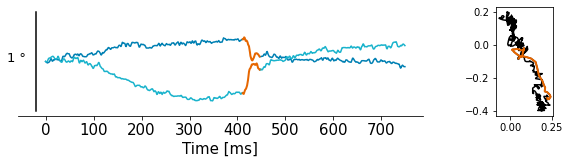

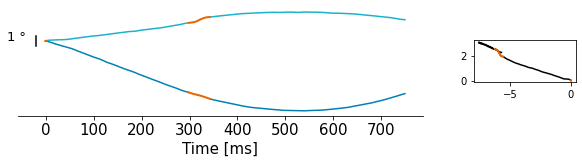

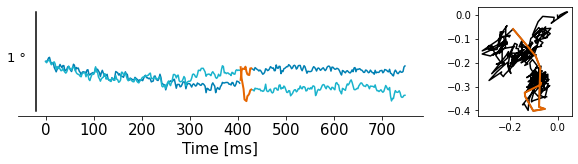

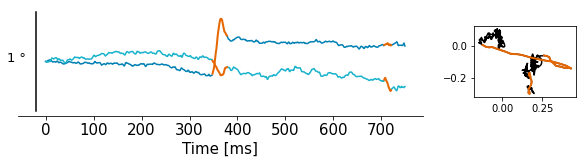

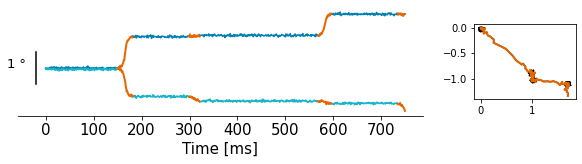

In [16]:
folders = ['dataset1','dataset2','dataset3','dataset4','Synthetic']
deg = [0.2,1,1,0.1,1,1]
ntime = 750; #time to plot (ms)
sampfreq = [1000,1000,500,1000,1000]
inds = [80,49,31,590,6] #trials to plot
for j,f in enumerate(folders):
    print(f)
    datapath = os.path.join('E:/BMD212-Midterm practical/project/uneye-master/uneye-master/data/',f)
    if f=='Synthetic':
        Xtrain = np.loadtxt(datapath+'/X_1000hz.csv',delimiter=',')
        Ytrain = np.loadtxt(datapath+'/Y_1000hz.csv',delimiter=',')
        Ltrain = np.loadtxt(datapath+'/Labels_1000hz.csv',delimiter=',')
    else:
        Xtrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_X_setA.csv',delimiter=',')
        Ytrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_Y_setA.csv',delimiter=',')
        Ltrain = np.loadtxt(datapath+'/'+f+'_'+str(sampfreq[j])+'hz_Labels_setA.csv',delimiter=',')


    i = inds[j]

    t = np.arange(0,ntime,1000/sampfreq[j])
    Xtrain = Xtrain[:,:int(ntime*(sampfreq[j]/1000))]
    Ytrain = Ytrain[:,:int(ntime*(sampfreq[j]/1000))]
    Ltrain = Ltrain[:,:int(ntime*(sampfreq[j]/1000))]
    l = Ltrain[i,:].astype(float).copy()
    
    f1 = figure(figsize=(10,2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
    x = Xtrain[i,:].copy()
    y = Ytrain[i,:].copy()
    x = x-x[0]
    y = y-y[0]
    
    ax = subplot(gs[0])
    xfix = x.copy(); xfix[l==1] = np.nan
    yfix = y.copy(); yfix[l==1] = np.nan
    plot(t,xfix,c=cols[0],label='horizontal') 
    plot(t,yfix,c=cols[1],label='vertical') 
    x[l==0] = np.nan
    y[l==0] = np.nan
    plot(t,x,c=cols[2],linewidth=2,label='saccade') 
    plot(t,y,c=cols[2],linewidth=2) 
    plot([-20,-20],[-0.5,0.5],'k')
    text(-80,0,str(1)+' °',fontsize=13)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    yticks(())
    xticks(fontsize=15)
    xlabel('Time [ms]',fontsize=15)
    
    x = Xtrain[i,:].copy()
    y = Ytrain[i,:].copy()
    x = x-x[0]
    y = y-y[0]
    ax = subplot(gs[1])
    plot(x,y,c='k',label='fixation')
    x[l==0] = np.nan
    y[l==0] = np.nan
    plot(x,y,c=cols[2],markersize=4,linewidth=2,label='saccade') 
    gca().set_aspect('equal',adjustable='box')
    #tight_layout()
    #savefig('examples_'+f+'.pdf',bbox_inches='tight')

# Training

Train network with training data (example data in folder 'data').

For training, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - ground truth labels for saccades (encoded as 1). Fixation encoded as 0. Additional labels are optional (e.g. post-saccadic oscillation, encoded as 2 etc.)      
**model.train(X,Y,Labels)**  

Optional input arguments when calling DNN() are:
- min_sacc_dur: minimum saccade duration (in ms) for removal of small saccades (post-processing), default: 1==no removal
- min_sacc_dist: minimum distance (in ms) between two saccades for merging of close-by saccades, default: 1==no merge
- weights_name: filename for storage of trained weights. All trained weights will automatically be safed in the local folder 'training'. The default filename is 'weights'
- augmentation: True or False. Whether data augmentation (rotation of signal) should be used. The default is 'True'.
- ks: kernel size of convolutional layers. Has to be odd. Default: 5
- mp: size of max pooling window. Has to be odd. Default: 5
- inf_correction: Float value to replace infs or NaNs in differentiated input data (i.e. eye velocity). Should correspond to maximum value that is expected. Default: 1.5
- val_samples: Number of trials used for validating when to stop training early. Default: 30

In [17]:
# Parameters 
min_sacc_dur = 6 #minimum saccade duration in ms
min_sacc_dist = 10 #minimum saccade distance in ms
sampfreq = 1000 #Hz
# OUR DATA
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'
labels_filename = 'Labels_1000hz.csv'

In [18]:
import numpy as np
import scipy.io as io
from os.path import join as pj

# load synthetic example data (.csv)
Xtrain = np.loadtxt(pj(x_filename),delimiter=',')
Ytrain = np.loadtxt(pj(y_filename),delimiter=',')
Ltrain = np.loadtxt(pj(labels_filename),delimiter=',')

# example dataset is large, so use only subset for training:
ntrain = 300 #samples for training
Xtrain = Xtrain[:ntrain,:]
Ytrain = Ytrain[:ntrain,:]
Ltrain = Ltrain[:ntrain,:]

# fit model on training data
# call model with optional arguments
model = DNN(sampfreq=sampfreq, min_sacc_dur=min_sacc_dur, min_sacc_dist=min_sacc_dist)
model.train(Xtrain,Ytrain,Ltrain)

Number of classes: 2
Using GPU: False
Training. Please wait.
Early stopping at epoch 21 before overfitting occurred.
Model parameters saved to ./training\weights


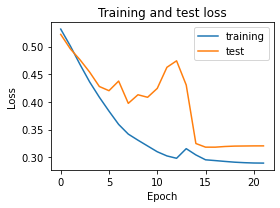

In [19]:
# plot loss
import matplotlib.pyplot as plt
f = plt.figure(figsize=(4,3))
plt.plot(model.loss_train,label='training')
plt.plot(model.loss_val,label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend()
plt.tight_layout()
plt.show()

## Testing and postprocessing 
#### Test performance and evaluation of the network after training on different datasets
For testing, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - ground truth labels for saccades (encoded as 1). Additional labels are optional (e.g. post-saccadic oscillation, encoded as 2 etc.) 

In [20]:
# OUR DATA 
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'
labels_filename = 'Labels_1000hz.csv'

# load example test data
Xtest = np.loadtxt(pj(x_filename),delimiter=',')
Ytest = np.loadtxt(pj(y_filename),delimiter=',')
Ltest = np.loadtxt(pj(labels_filename),delimiter=',')

# reduce data to subset that wasn't used for training (only needed for this example)
Xtest = Xtest[ntrain:,:]
Ytest = Ytest[ntrain:,:]
Ltest = Ltest[ntrain:,:]

# test performance (here on subset of data that wasn't used for training)
Prediction,Probability,Performance = model.test(Xtest,Ytest,Ltest)

Binary Cohens Kappa:  0.936


<ipython-input-6-490b18543b30>:229: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if content_of_pred!=[]:
<ipython-input-6-490b18543b30>:229: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if content_of_pred!=[]:


F1: 0.974


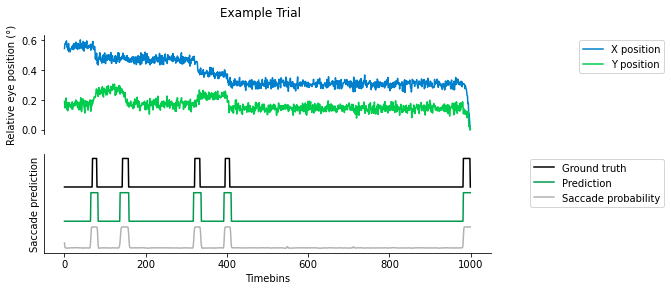

In [21]:
# plot example
i = np.random.randint(Xtest.shape[0])
fig = plt.figure(figsize=(8,4))
plt.suptitle('Example Trial')
ax = fig.add_subplot(211)
x_trace = Xtest[i,:] - np.min(Xtest[i,:])
y_trace = Ytest[i,:] - np.min(Ytest[i,:])
plt.plot(x_trace,label='X position',c=[0,0.5,0.8])
plt.plot(y_trace,label='Y position',c=[0,0.8,0.3])
plt.xticks(())
plt.ylabel('Relative eye position (°)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(bbox_to_anchor=(1.4,1))

# prediction
ax = fig.add_subplot(212)
plt.plot(Ltest[i,:]+2.4,label='Ground truth',c='k')
plt.plot(Prediction[i,:]+1.2,label='Prediction',c=[0,0.6,0.3])
plt.plot(Probability[i,:],label='Saccade probability',c='k',alpha=.3)
plt.yticks(())
plt.ylabel('Saccade prediction')
plt.xlabel('Timebins')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()

# Saccade prediction with pretrained network
Predict eye-movements in data (synthetic example data in folder 'data').
For prediction, 3 inputs are **necessary**:
    - horizontal eye position (in deg)
    - vertical eye position (in deg)
    - sampling frequency of the eye tracker  
Call the model and then run prediction with the method **model.predict()**

In [32]:
import numpy as np

# Parameters 
sampfreq = 1000 #Hz
min_sacc_dur = 6 # in ms
min_sacc_dist = 10 #in ms

# Data
x_filename = 'X_1000hz.csv'
y_filename = 'Y_1000hz.csv'

# load data
Xtest = np.loadtxt(pj(x_filename),delimiter=',')
Ytest = np.loadtxt(pj(y_filename),delimiter=',')

### Model Prediction

In [33]:
model = DNN(sampfreq=sampfreq, min_sacc_dur=min_sacc_dur, min_sacc_dist=min_sacc_dist)
Prediction,Probability = model.predict(Xtest,Ytest)

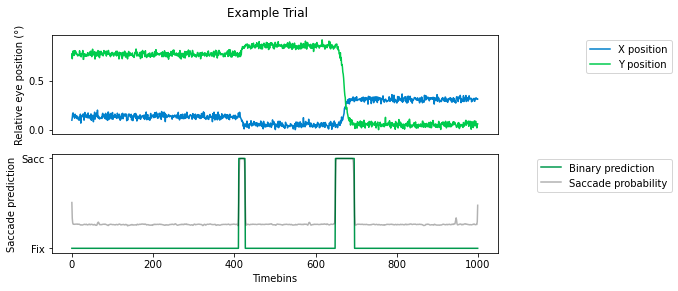

In [34]:
import matplotlib.pyplot as plt
# plot example
i = np.random.randint(Xtest.shape[0])
fig = plt.figure(figsize=(8,4))
plt.suptitle('Example Trial')
ax = fig.add_subplot(211)
x_trace = Xtest[i,:] - np.min(Xtest[i,:])
y_trace = Ytest[i,:] - np.min(Ytest[i,:])
plt.plot(x_trace,label='X position',c=[0,0.5,0.8])
plt.plot(y_trace,label='Y position',c=[0,0.8,0.3])
plt.xticks(())
plt.ylabel('Relative eye position (°)')
plt.legend(bbox_to_anchor=(1.4,1))

# prediction
ax = fig.add_subplot(212)
plt.plot(Prediction[i,:],label='Binary prediction',c=[0,0.6,0.3])
plt.plot(Probability[i,1,:],label='Saccade probability',c='k',alpha=.3)
plt.yticks((0,1),['Fix','Sacc'])
plt.ylabel('Saccade prediction')
plt.xlabel('Timebins')
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()